Calculating a recombination map from crossovers

So I found a paper https://www.nature.com/articles/hdy201195#Sec15 where thye show recombination maps in all the chromosomes of arabidopsis thaliana. 
I downloaded their data and they only have XO counts, so basically crossover event counts across SNPs in all the populations they grew

They grew 17 different populations and had approximately 64 markers (SNPS), so they have information about the number of crosses in between markers, the location of the markers, and an estimation of where the cross happened (this is just a middlepoint in between the markers).

The recombination rate will be:

Recombination rate = Genetic distance / Physical distance

So for that, i took they data they have on genetic distance calculated based on the Haldane fromula (notice that they have it as an acumulation across markers), so first i had to caclulate the actual genetic distance among the markers, and then calculate the physical distance (distance in mbp between markers) and with all that calculate the recombination rate. 



Imports

In [218]:
import numpy as np
import pandas as pd
import xlrd
import random

import seaborn as sns
import matplotlib.pyplot as plt

Code

In [627]:
gd = pd.ExcelFile("maps K H CF.xls")

In [647]:
all_pop = pd.DataFrame()
for sheet in gd.sheet_names: 
    sheetdf = gd.parse(sheet)
    row, col = np.where(sheetdf == 'chromosome 5')
    row, col = row[0], col[0]
    chr5 = sheetdf.iloc[row:, col:]
    chr5.columns = chr5.iloc[2]
    chr5['snp_right'] = chr5['SNP'].str.replace('5-', '')
    chr5['snp_left'] = chr5['snp_right']
    chr5['snp_left'] = chr5['snp_left'].shift(1)

    chr5 = chr5.drop([1,2,3,4]) 
    chr5['physical_distance'] = chr5['snp_right'].astype(float) - chr5['snp_left'].astype(float) 
    chr5['physical_distance_mbp'] = chr5['physical_distance'] / 1000000
    chr5['midpoint'] = (chr5['snp_right'].astype(float) + chr5['snp_left'].astype(float))/2
    chr5['midpoint_mbp'] = chr5['midpoint'] /1000000

    chr5['gd'] = chr5['H'].diff()
    chr5 = chr5.reset_index(drop=True)
    chr5.loc[0,'gd'] =  chr5.loc[0,'H']
    chr5['recomb_rate'] = chr5['gd'] / chr5['physical_distance_mbp']
    chr5['pop'] = sheet.split()[0]
    all_pop= pd.concat([all_pop, chr5],axis=0)
    

In [648]:
all_pop = all_pop.dropna()

In [683]:
recomb_rate_mean = all_pop.groupby(['midpoint_mbp'])['recomb_rate'].mean().reset_index()

In [657]:
recomb_rate_mean['pop'] = 'mean'

In [684]:
recomb_rate = all_pop.groupby(['midpoint_mbp','pop'])['recomb_rate'].mean().reset_index()

In [689]:
recomb_rate['recomb_rate'].mean()

3.7494082526297445

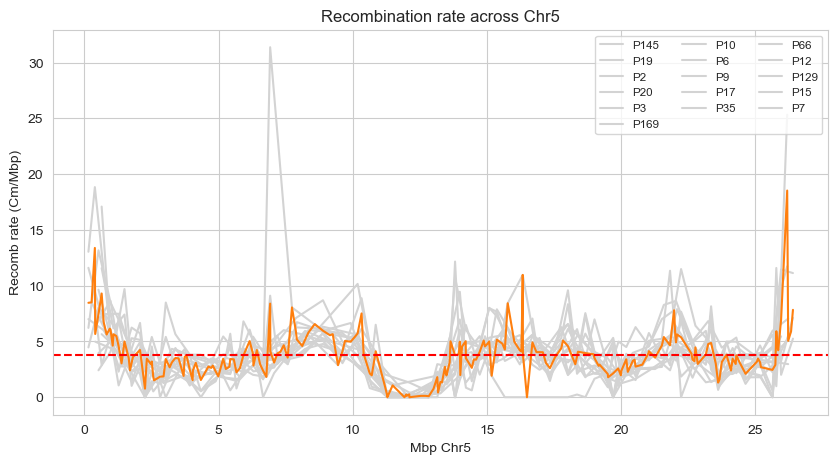

In [692]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(data=recomb_rate, x='midpoint_mbp', y='recomb_rate',hue='pop',ax=ax, palette=['lightgrey']*16)
sns.lineplot(data=recomb_rate_mean, x='midpoint_mbp', y='recomb_rate',ax=ax)
ax.legend(loc='upper right', fontsize='small', ncol=3)

plt.xlabel('Mbp Chr5')
plt.ylabel('Recomb rate (Cm/Mbp)')
plt.title('Recombination rate across Chr5')

# Add horizontal asymptote, mean recomb rate 
plt.axhline(y=recomb_rate['recomb_rate'].mean(), color='r', linestyle='--')

plt.show()

In [ ]:
#### but for slim format i have to give the rate and the end of the chunk 

In [723]:
all_pop

3,SNP,K,H,CF,snp_right,snp_left,physical_distance,physical_distance_mbp,midpoint,midpoint_mbp,gd,recomb_rate,pop
0,5-271377,3.086587,3.181797,3.082682,271377,27343,244034.0,0.244034,149360.0,0.149360,3.181797,13.038335,P2
1,5-508090,7.361843,7.639608,7.347593,508090,271377,236713.0,0.236713,389733.5,0.389734,4.457811,18.832134,P2
2,5-1384732,12.486854,13.026818,12.454843,1384732,508090,876642.0,0.876642,946411.0,0.946411,5.38721,6.145279,P2
3,5-1603469,13.109519,13.65336,13.077475,1603469,1384732,218737.0,0.218737,1494100.5,1.494101,0.626542,2.864362,P2
4,5-1917139,14.742004,15.31249,14.709381,1917139,1603469,313670.0,0.313670,1760304.0,1.760304,1.65913,5.289412,P2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,5-23447475,72.118906,74.22347,72.009874,23447475,23272788,174687.0,0.174687,23360131.5,23.360132,1.062074,6.079869,P169
47,5-23796622,72.416622,74.522072,72.307586,23796622,23447475,349147.0,0.349147,23622048.5,23.622048,0.298602,0.855233,P169
48,5-24757037,75.082381,77.258861,74.970827,24757037,23796622,960415.0,0.960415,24276829.5,24.276830,2.736789,2.84959,P169
49,5-25683652,77.513474,79.749032,77.400008,25683652,24757037,926615.0,0.926615,25220344.5,25.220344,2.490171,2.687385,P169


In [737]:
recomb_rate_slim = all_pop.groupby(['snp_left','snp_right'])['recomb_rate'].mean().reset_index()

In [738]:
recomb_rate_slim['snp_right'] = recomb_rate_slim['snp_right'].astype(int)

In [739]:
## also the rate for slim. from cm/mbp to we ahve to multiply *  1e-8 becuase cM/Mbp to a rate per base 
#pair per gamete, as used by SLiM, by multiplying by 10−8, a conversion ratio that comes from the  units involved.  1 cM means that there is a probability of 0.01 of crossover during meiosis.  
# Therefore, 1 cM/Mbp = 10−6 cM/bp = 10−8 probability of crossover per base pair.

In [740]:
recomb_rate_slim['recomb_rate'] = recomb_rate_slim['recomb_rate'] * 1e-8

In [741]:
recomb_rate_slim = recomb_rate_slim.sort_values(by='snp_right', ascending=True)

In [742]:
recomb_rate_slim.head(20)

,snp_left,snp_right,recomb_rate
146,27343,271377,8.463229e-08
147,27343,508090,8.501235e-08
144,271377,508090,1.338074e-07
148,27343,778236,5.668129e-08
174,508090,778236,9.297339e-08
145,271377,778236,7.443236e-08
197,778236,1166716,6.071844e-08
142,271377,1166716,6.722037e-08
172,508090,1384732,6.145279e-08
12,1166716,1384732,4.579438e-08


In [699]:
recomb_rate_mean['pos'] = (recomb_rate_mean['midpoint_mbp'] * 1000000).round().astype(int)

In [703]:
recomb_rate_mean = recomb_rate_mean.drop('midpoint_mbp',axis=1)[['pos', 'recomb_rate']]

In [704]:
recomb_rate_mean

,pos,recomb_rate
0,149360,8.463229
1,267716,8.501235
2,389734,13.380742
3,402790,5.668129
4,524806,7.443236
...,...,...
211,25969894,6.960439
212,26197334,18.524188
213,26233649,5.051908
214,26341660,5.912034


In [706]:
recomb_rate_mean.to_csv('recomb_map.csv',header=None, index=None)

In [707]:
26.9 * 1000000

26900000.0